In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
import optuna

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

In [2]:
# importing transformations for feature pipeline from .py script
from pipeline_helpers.feature_transformations import *
from pipeline_helpers.target_transformation import *

### Configuration

In [3]:
# set visibility for all the columns
pd.set_option('display.max_columns', None)

In [4]:
def missing_data_info(df):
    total_missing = df.isnull().sum()
    percent_missing = (df.isnull().sum() / df.shape[0]) * 100
    
    # Combine the results into a DataFrame and sort by the 'Percent' column
    missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data['Percent'] > 0].sort_values(by='Percent', ascending=False)
    
    return missing_data

### Data Loading

In [5]:
# Load the datasets
train_df = pd.read_csv('data/Training_dataset.csv')
test_df = pd.read_csv('data/Test_dataset.csv')

In [6]:
missing_data_info(train_df)

,Total,Percent
VehColorInt,728,11.559225
Vehicle_Trim,405,6.430613
VehDriveTrain,401,6.367101
VehEngine,361,5.731978
VehPriceLabel,285,4.525246
VehFeats,275,4.366466
VehSellerNotes,243,3.858368
VehHistory,201,3.191489
VehTransmission,197,3.127977
VehColorExt,73,1.159098


### Preparation of target variables

In [7]:
train_df_final = preprocessing_target_variables(train_df)

## 1. Classifier - Vehicle_Trim

### Training and preprocessing using pipeline

In [8]:
# Label encode Vehicle_Trim
le = LabelEncoder()
y = le.fit_transform(train_df_final['Vehicle_Trim'])

# Split data into training and test sets
X = train_df_final.drop(['Vehicle_Trim', 'Dealer_Listing_Price'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(np.unique(y))
print(np.unique(y_train))
print(np.unique(y_valid))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [10]:
# Define and use your transformation pipeline on X
CURRENT_YEAR = 2023
index_feature = ['ListingID']
unused_features = ['VehTransmission','VehBodystyle','SellerZip','VehType','VehSellerNotes',
                       'VehPriceLabel','VehModel','SellerIsPriv','SellerName','SellerCity']

log_transform_features = ['SellerRevCnt', 'VehListdays']
boolean_feature = ['VehCertified']
one_hot_features = ['SellerListSrc', 'SellerState', 'VehFuel', 'VehDrive','BasicExtColor','Engine_Category']

preprocessing_pipeline = Pipeline([
    ("set_index", SetIndex(index_feature=index_feature)),
    ("drop_unused", DropUnused(features=unused_features)),
    ("log_transform", LogTransform(features=log_transform_features)),
    ("age_feature", AgeFeatureTransform(current_year=CURRENT_YEAR)),
    ("boolean_encode", BooleanEncoding(features=boolean_feature)),
    ('veh_drive_train_transform', VehDriveTrainTransform()),
    ('veh_feats_transform', VehFeatsTransform()),
    ('veh_color_ext_transform', VehColorExtTransform()),
    ('veh_color_int_transform', VehColorInternalTransform()),
    ('veh_engine_transform', VehEngineTransform()),
    ('veh_make_transform', VehMakeTransform()),
    ('veh_mileage_transform', VehMileageTransform()),
    ('veh_history_transform', VehHistoryTransform()),
    ("column_transformer", ColumnTransformer([
        ("one_hot_encode", OneHotEncoder(handle_unknown='ignore', dtype=int), 
         one_hot_features)], remainder='passthrough'))])

- `remainder=passthrough` argument ensures that columns not explicitly specified in the transformer list are left unchanged.
- `handle_unknown=ignore` ensures that unseen categories in the test set won't cause errors and will be ignored. This is essential to handle potential differences in categories between the training and test datasets.

In [11]:
# Transform the train and validation data
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_valid_transformed = preprocessing_pipeline.transform(X_valid)

In [12]:
print('Original X_train shape:',X_train.shape)
print('Transformed X_train shape:',X_train_transformed.shape)
print('y_train shape:',y_train.shape)

Original X_train shape: (4642, 27)
Transformed X_train shape: (4642, 94)
y_train shape: (4642,)


#### Classifier Baseling Model Training

ROC Score:  0.9392575340413764
              precision    recall  f1-score   support

           0       0.51      0.24      0.33        92
           1       0.61      0.52      0.56        42
           2       0.57      0.42      0.48       150
           3       0.64      0.88      0.74       380
           4       0.56      0.69      0.62       123
           5       0.61      0.42      0.50       121
           6       0.81      0.68      0.74        37
           7       0.80      0.71      0.75       147
           8       1.00      1.00      1.00        23
           9       0.70      0.50      0.58        46

    accuracy                           0.65      1161
   macro avg       0.68      0.61      0.63      1161
weighted avg       0.64      0.65      0.63      1161



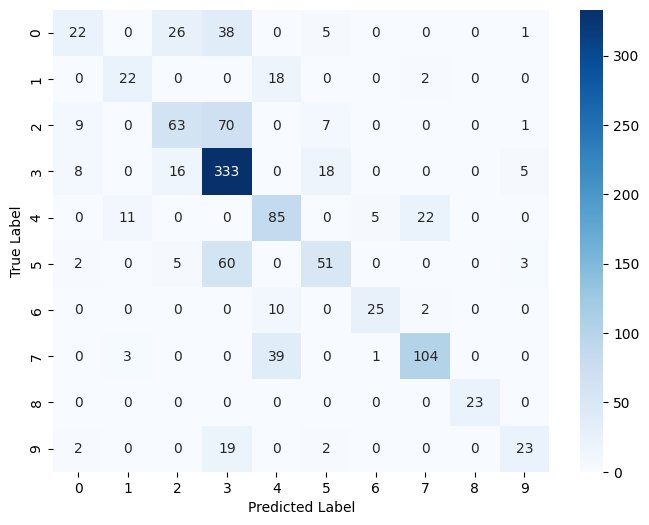

In [13]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='merror')
model.fit(X_train_transformed, y_train) 

# Predictions
y_valid_prob  = model.predict_proba(X_valid_transformed)
y_valid_label = np.argmax(y_valid_prob, axis=1)

roc_auc = roc_auc_score(y_valid, y_valid_prob, multi_class='ovr')

print('ROC Score: ',roc_auc)

report = classification_report(y_valid, y_valid_label)
print(report)

cm = confusion_matrix(y_valid, y_valid_label)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Hyperparameter Tunning using Optuna

In [15]:
def objective(trial):
    # Define hyperparameter search space
    print('Trial: ', trial.number)

        
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'use_label_encoder': False,
        'eval_metric': 'merror'
    }

    # Initialize and train classifier
    model = xgb.XGBClassifier(**param)
    model.fit(X_train_transformed, y_train, eval_set=[(X_valid_transformed, y_valid)], verbose=False)

    # Predictions
    y_valid_prob  = model.predict_proba(X_valid_transformed)
    y_valid_label = np.argmax(y_valid_prob, axis=1)

    roc_auc = roc_auc_score(y_valid, y_valid_prob, multi_class='ovr')

    # Return AUC
    return roc_auc

In [16]:
# Initiate the optimizer
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Results
print(f"Number of finished trials: {len(study.trials)}\n")
print(f"Best trial parameters: {study.best_trial.params}\n")
print(f"Best AUC: {study.best_value}")

[I 2023-10-26 11:59:11,696] A new study created in memory with name: no-name-88d3a4ba-4fad-49b7-b42d-0916056c1e2c


Trial:  0


[I 2023-10-26 11:59:13,389] Trial 0 finished with value: 0.9343284603295745 and parameters: {'n_estimators': 184, 'max_depth': 7, 'learning_rate': 0.20801540858510095, 'subsample': 0.7790570514833028, 'colsample_bytree': 0.8666208615355606, 'gamma': 0.1652390606905048, 'lambda': 0.08699160504393891, 'alpha': 0.00012048685617050913, 'min_child_weight': 7}. Best is trial 0 with value: 0.9343284603295745.


Trial:  1


[I 2023-10-26 11:59:20,107] Trial 1 finished with value: 0.9362333893642584 and parameters: {'n_estimators': 801, 'max_depth': 9, 'learning_rate': 0.39601121987977494, 'subsample': 0.7650159265566437, 'colsample_bytree': 0.6273346226955602, 'gamma': 0.10202640804337887, 'lambda': 0.01997463980098406, 'alpha': 1.2683410353550242e-08, 'min_child_weight': 1}. Best is trial 1 with value: 0.9362333893642584.


Trial:  2


[I 2023-10-26 11:59:26,124] Trial 2 finished with value: 0.9360699869761987 and parameters: {'n_estimators': 325, 'max_depth': 9, 'learning_rate': 0.10975716677532411, 'subsample': 0.5104383346628856, 'colsample_bytree': 0.9297716683863197, 'gamma': 0.16840630457856298, 'lambda': 9.591265648797883e-05, 'alpha': 1.6353143570297765e-06, 'min_child_weight': 1}. Best is trial 1 with value: 0.9362333893642584.


Trial:  3


[I 2023-10-26 11:59:35,347] Trial 3 finished with value: 0.9353057097405321 and parameters: {'n_estimators': 570, 'max_depth': 7, 'learning_rate': 0.0052797577098333374, 'subsample': 0.7746808767128921, 'colsample_bytree': 0.5976373765384495, 'gamma': 0.13062136736410251, 'lambda': 3.728684556334089e-07, 'alpha': 0.0047486993125976235, 'min_child_weight': 7}. Best is trial 1 with value: 0.9362333893642584.


Trial:  4


[I 2023-10-26 11:59:38,471] Trial 4 finished with value: 0.9385495054063785 and parameters: {'n_estimators': 202, 'max_depth': 8, 'learning_rate': 0.03772422362383541, 'subsample': 0.7877151952304214, 'colsample_bytree': 0.735922547889562, 'gamma': 0.07579306701012806, 'lambda': 1.610815709269123e-05, 'alpha': 8.19233708623463e-06, 'min_child_weight': 10}. Best is trial 4 with value: 0.9385495054063785.


Trial:  5


[I 2023-10-26 11:59:50,471] Trial 5 finished with value: 0.9358854363896464 and parameters: {'n_estimators': 891, 'max_depth': 8, 'learning_rate': 0.11007202291646828, 'subsample': 0.8286542801819421, 'colsample_bytree': 0.8851902127087519, 'gamma': 0.09853087697641105, 'lambda': 2.38519338277534e-05, 'alpha': 4.6743428538427764e-08, 'min_child_weight': 5}. Best is trial 4 with value: 0.9385495054063785.


Trial:  6


[I 2023-10-26 11:59:51,705] Trial 6 finished with value: 0.9391311339253695 and parameters: {'n_estimators': 110, 'max_depth': 6, 'learning_rate': 0.369124703659327, 'subsample': 0.9401069732556883, 'colsample_bytree': 0.7109187895427591, 'gamma': 0.3806574389570756, 'lambda': 3.167780550949483e-05, 'alpha': 8.976130225489175e-05, 'min_child_weight': 2}. Best is trial 6 with value: 0.9391311339253695.


Trial:  7


[I 2023-10-26 11:59:57,489] Trial 7 finished with value: 0.9418972044013983 and parameters: {'n_estimators': 368, 'max_depth': 8, 'learning_rate': 0.03357107206875864, 'subsample': 0.934323784634609, 'colsample_bytree': 0.8021900331755882, 'gamma': 0.43104549562855793, 'lambda': 5.897496138692197e-05, 'alpha': 0.41653420328823987, 'min_child_weight': 6}. Best is trial 7 with value: 0.9418972044013983.


Trial:  8


[I 2023-10-26 12:00:08,904] Trial 8 finished with value: 0.9375194364571341 and parameters: {'n_estimators': 732, 'max_depth': 5, 'learning_rate': 0.05587686576374841, 'subsample': 0.5763810578117787, 'colsample_bytree': 0.9166762657948937, 'gamma': 0.15946639083351144, 'lambda': 0.035556342018008516, 'alpha': 0.13313179151433943, 'min_child_weight': 1}. Best is trial 7 with value: 0.9418972044013983.


Trial:  9


[I 2023-10-26 12:00:17,523] Trial 9 finished with value: 0.9349622875082396 and parameters: {'n_estimators': 574, 'max_depth': 5, 'learning_rate': 0.012983699299847851, 'subsample': 0.5999618596024573, 'colsample_bytree': 0.9946464146898829, 'gamma': 0.4560172640553016, 'lambda': 2.7526006349105397e-07, 'alpha': 2.704962568461496e-08, 'min_child_weight': 8}. Best is trial 7 with value: 0.9418972044013983.


Number of finished trials: 10

Best trial parameters: {'n_estimators': 368, 'max_depth': 8, 'learning_rate': 0.03357107206875864, 'subsample': 0.934323784634609, 'colsample_bytree': 0.8021900331755882, 'gamma': 0.43104549562855793, 'lambda': 5.897496138692197e-05, 'alpha': 0.41653420328823987, 'min_child_weight': 6}

Best AUC: 0.9418972044013983


#### Classification on unseen test set

In [17]:
X_test_transformed = preprocessing_pipeline.transform(test_df)

In [18]:
print('Original X_train shape:',X_train.shape)
print('Transformed X_train shape:',X_train_transformed.shape)
print('y_train shape:',y_train.shape)
print()
print('Original X_test shape:',test_df.shape)
print('Transformed X_test shape:',X_test_transformed.shape)

Original X_train shape: (4642, 27)
Transformed X_train shape: (4642, 94)
y_train shape: (4642,)

Original X_test shape: (1000, 27)
Transformed X_test shape: (1000, 94)


In [19]:
# Predictions
y_test_prob  = model.predict_proba(X_test_transformed)
y_test_label = np.argmax(y_test_prob, axis=1)

In [20]:
y_test_label[:5]

array([7, 3, 0, 3, 4], dtype=int64)